# Modular variables

In [1]:
from IPython import get_ipython
if get_ipython():
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import collections

import latenta as la
la.logger.setLevel("INFO")

## Simple example

In [2]:
n_cells = 50
cell_ids = [str(i) for i in range(n_cells)]
cells = la.Dim(pd.Series(cell_ids, name = "cell"))

x = la.Fixed(pd.Series(np.random.uniform(0, 3, n_cells), index = cells.index), label = "x")

In [3]:
n_genes = 100
genes = la.Dim(pd.Series([str(i) for i in range(n_genes)]), id = "gene")

def random_coefficient(n_genes):
    return np.random.choice([-1, 1], n_genes) * np.random.normal(3., 1., n_genes) * (np.random.random(n_genes) > 0.5)

slope = la.Fixed(pd.Series(random_coefficient(n_genes), index = genes.index), label = "slope")
intercept = la.Fixed(pd.Series(random_coefficient(n_genes), index = genes.index), label = "intercept")
final = la.Fixed(pd.Series(random_coefficient(n_genes), index = genes.index), label = "final")

slope_subset = la.Fixed(pd.Series(random_coefficient(10), index = genes.index[:10]), label = "slope_subset")

In [4]:
y_linear = la.links.scalar.Linear(x = x, a = slope)
y = la.modular.Additive(linear = y_linear, definition = y_linear.value_definition, subsettable = ("gene", ))

We can add extra terms:

In [5]:
y_sigmoid = la.links.scalar.Sigmoid(x = x, a = final)
y.sigmoid = y_sigmoid

y_exponential = la.links.scalar.Exp(x = x, a = final)
y.exponential = y_exponential

The terms can have a subset of the modular variable's dimensions:

In [6]:
y.simply_x = x
y.simply_slope = slope

In fact, a terms dimension can be a subset, as long as this dimension was registered as "subsettable" when defining the modular variable:

In [7]:
y_linear_subset = la.links.scalar.Linear(x = x, a = slope_subset)
y.linear_subset = y_linear_subset
y_linear.prior_xr().shape, y_linear_subset.prior_xr().shape

((50, 100), (50, 10))

We can also remove terms

In [8]:
del y.exponential

In [9]:
scale = la.Fixed(pd.Series(np.random.uniform(1., 1.2, n_genes), index = genes.index), label = "scale")
dist = la.distributions.Normal(loc = y, scale = scale)


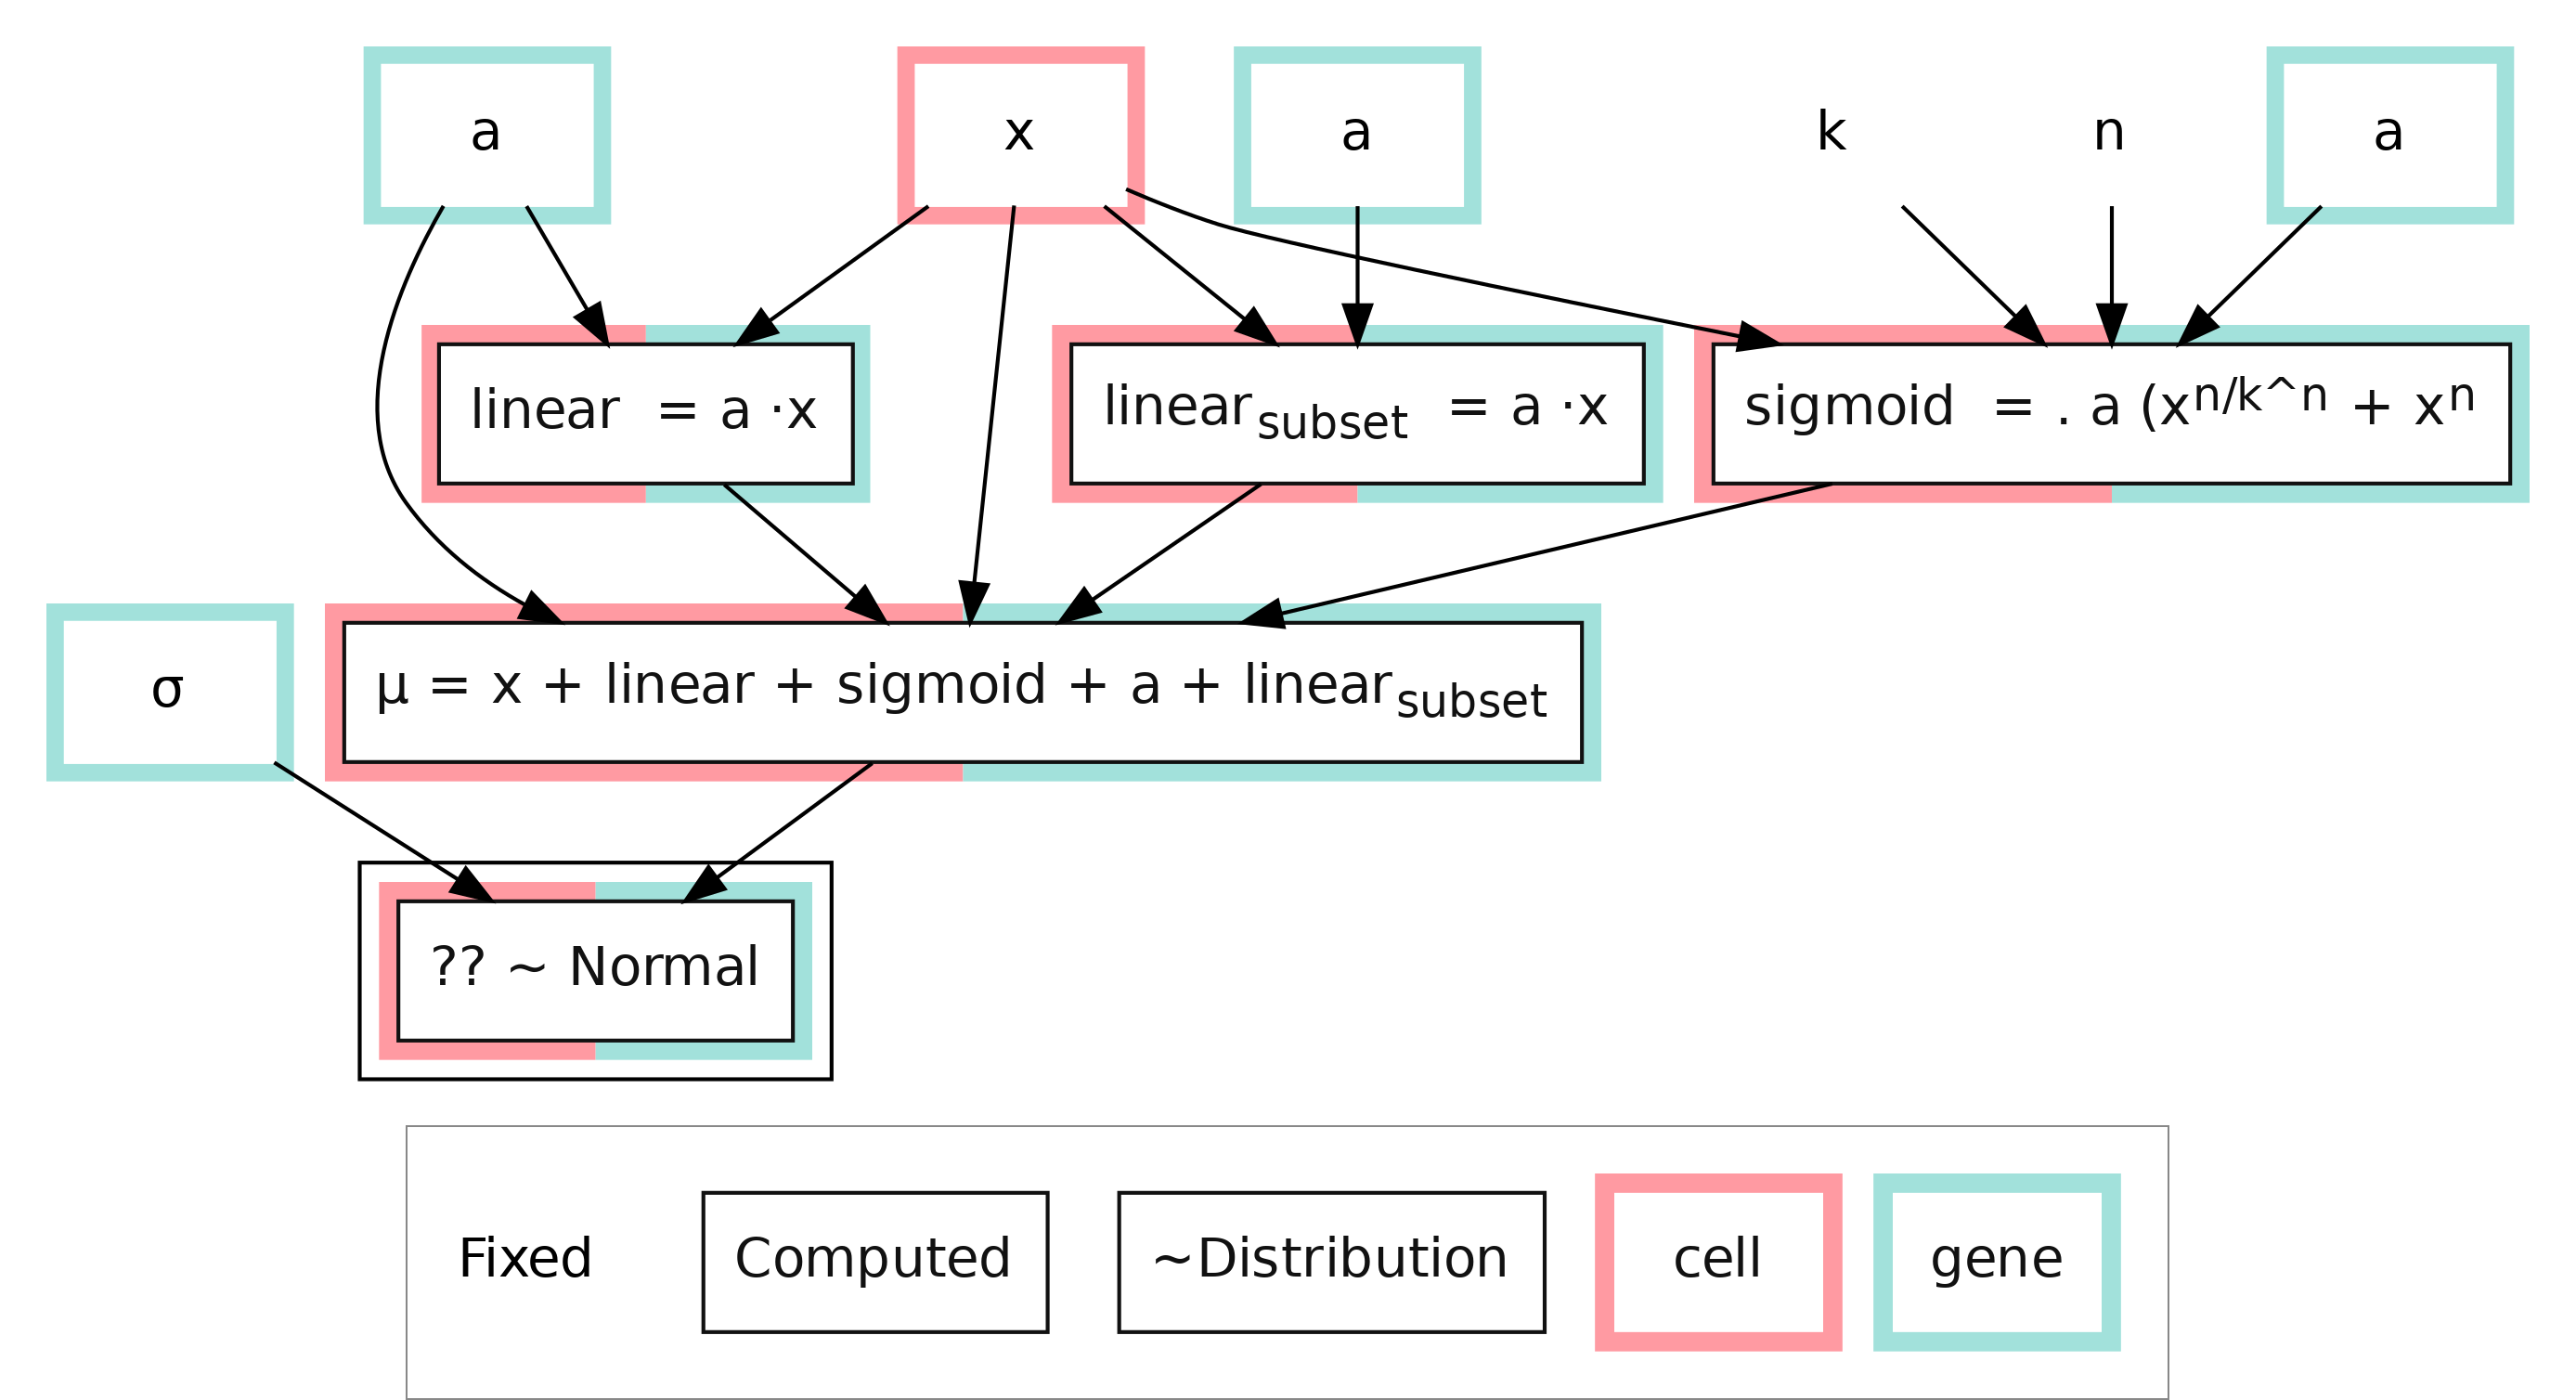

In [10]:
model_gs = la.Model(dist, label = "ground truth", symbol = "gs")
model_gs.plot()

In [11]:
posterior = la.posterior.Posterior(dist)
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

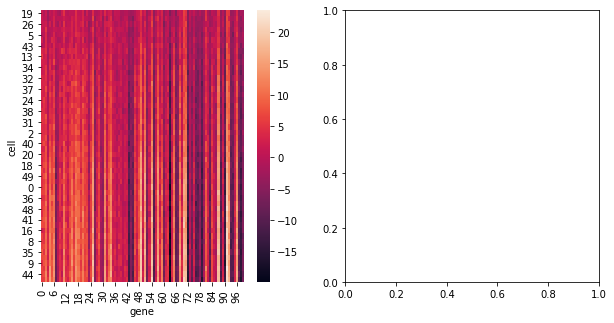

In [12]:
observation_value = posterior.samples[dist].sel(sample = 0).to_pandas()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (10, 5))
cell_order = model_gs.find_recursive("x").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax = ax0)

## Types of modular variables

In [13]:
y = la.modular.Multiplicative(linear = y_linear, linear_subset = y_linear_subset, definition = y_linear.value_definition, subsettable = ("gene", ))

In [14]:
y.prior_pd()

gene,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,-32.684605,0.0,0.0,0.0,-0.0,0.0,0.0,...,-9.690289,11.229775,7.709282,-5.998855,-7.388564,0.0,7.317862,-5.098053,-8.017638,-5.251151
1,0.0,0.0,0.0,-8.078051,0.0,0.0,0.0,-0.0,0.0,0.0,...,-4.817462,5.582808,3.832618,-2.982291,-3.673175,0.0,3.638026,-2.534463,-3.985915,-2.610575
2,0.0,0.0,0.0,-9.745142,0.0,0.0,0.0,-0.0,0.0,0.0,...,-5.291261,6.131878,4.209557,-3.275599,-4.034432,0.0,3.995827,-2.783728,-4.377931,-2.867325
3,0.0,0.0,0.0,-47.776447,0.0,0.0,0.0,-0.0,0.0,0.0,...,-11.715802,13.577079,9.320714,-7.252765,-8.932959,0.0,8.847479,-6.163674,-9.693525,-6.348773
4,0.0,0.0,0.0,-0.113220,0.0,0.0,0.0,-0.0,0.0,0.0,...,-0.570330,0.660938,0.453736,-0.353068,-0.434860,0.0,0.430699,-0.300050,-0.471885,-0.309061
5,0.0,0.0,0.0,-0.110352,0.0,0.0,0.0,-0.0,0.0,0.0,...,-0.563060,0.652513,0.447953,-0.348567,-0.429317,0.0,0.425209,-0.296226,-0.465870,-0.305121
6,0.0,0.0,0.0,-41.584919,0.0,0.0,0.0,-0.0,0.0,0.0,...,-10.930324,12.666813,8.695813,-6.766508,-8.334054,0.0,8.254305,-5.750434,-9.043630,-5.923123
7,0.0,0.0,0.0,-9.569588,0.0,0.0,0.0,-0.0,0.0,0.0,...,-5.243384,6.076396,4.171468,-3.245961,-3.997928,0.0,3.959672,-2.758540,-4.338319,-2.841381
8,0.0,0.0,0.0,-44.269672,0.0,0.0,0.0,-0.0,0.0,0.0,...,-11.277640,13.069307,8.972127,-6.981518,-8.598873,0.0,8.516590,-5.933157,-9.330996,-6.111334
